In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

#device = torch.device("mps")
device = torch.device("cpu")
print(device, torch.__version__)
#torch.manual_seed(1802)

from dstft import fastDSTFT

mat = loadmat("../data/fan_flutter.mat")["x"]
x_sample = torch.from_numpy(mat).float()[:, 4_000:10_000]

reg = 0.01

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

def time_function(f, device, time_list=None, *args, **kwargs):
    if device.type in ['mps', 'cuda']:
        torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()
    start = time.time()
    result = f(*args, **kwargs)
    if device.type in ['mps', 'cuda']:
        torch.cuda.synchronize() if device.type == 'cuda' else torch.mps.synchronize()
    end = time.time()
    elapsed = end-start
    if time_list is None:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    else:
        time_list.append(elapsed)
    return result


cpu 2.7.0


Here, the fastDSTFT is tested

tensor([-5.0000e-01,  4.9500e+01,  9.9500e+01,  1.4950e+02,  1.9950e+02,
         2.4950e+02,  2.9950e+02,  3.4950e+02,  3.9950e+02,  4.4950e+02,
         4.9950e+02,  5.4950e+02,  5.9950e+02,  6.4950e+02,  6.9950e+02,
         7.4950e+02,  7.9950e+02,  8.4950e+02,  8.9950e+02,  9.4950e+02,
         9.9950e+02,  1.0495e+03,  1.0995e+03,  1.1495e+03,  1.1995e+03,
         1.2495e+03,  1.2995e+03,  1.3495e+03,  1.3995e+03,  1.4495e+03,
         1.4995e+03,  1.5495e+03,  1.5995e+03,  1.6495e+03,  1.6995e+03,
         1.7495e+03,  1.7995e+03,  1.8495e+03,  1.8995e+03,  1.9495e+03,
         1.9995e+03,  2.0495e+03,  2.0995e+03,  2.1495e+03,  2.1995e+03,
         2.2495e+03,  2.2995e+03,  2.3495e+03,  2.3995e+03,  2.4495e+03,
         2.4995e+03,  2.5495e+03,  2.5995e+03,  2.6495e+03,  2.6995e+03,
         2.7495e+03,  2.7995e+03,  2.8495e+03,  2.8995e+03,  2.9495e+03,
         2.9995e+03,  3.0495e+03,  3.0995e+03,  3.1495e+03,  3.1995e+03,
         3.2495e+03,  3.2995e+03,  3.3495e+03,  3.3

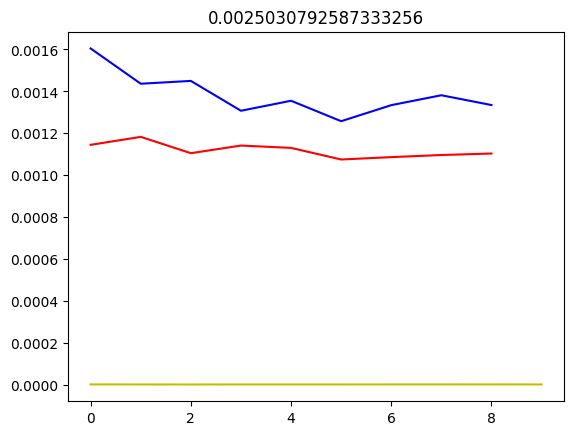

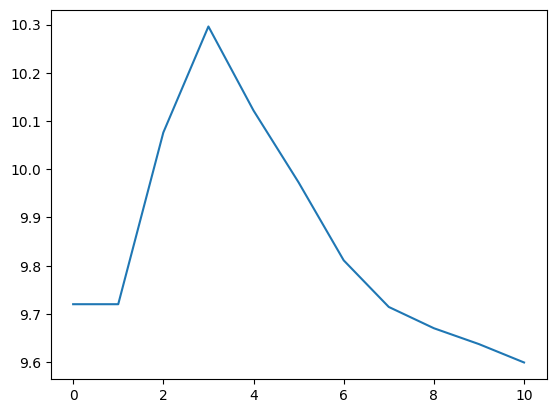

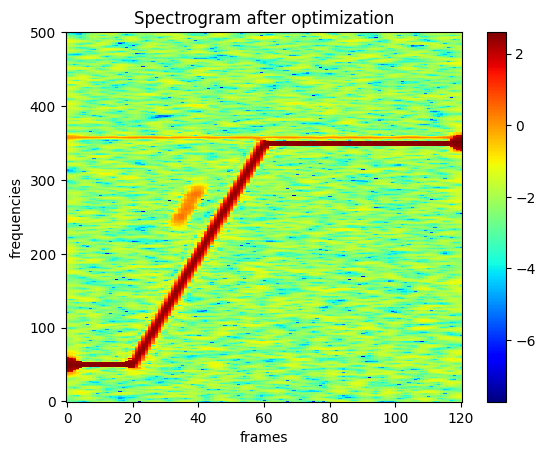

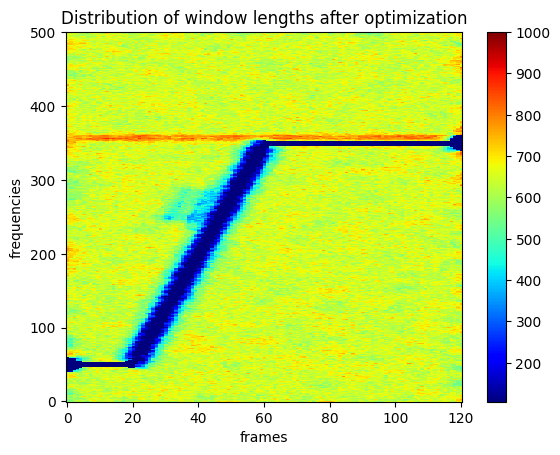

105.89028 1000.0 614.8868
finished on epoch 9 with (unregularized) loss 9.104808807373047


'transformed_window_lengths = fastdstft.window_transform(window_lengths)\nprint(transformed_window_lengths.min(), transformed_window_lengths.max())\ntransformed_back_window_lengths = fastdstft.inverse_window_transform(torch.tensor(transformed_window_lengths))\nprint(transformed_back_window_lengths.min(), transformed_back_window_lengths.max())\ntransform_error = torch.tensor(window_lengths) -transformed_back_window_lengths\nprint(transform_error.min(), transform_error.max())'

In [ ]:
batch_size = 64
x = x_sample.repeat(batch_size, 1).to(device)
#x = torch.randn(1, 6026, device=device)
fastdstft = fastDSTFT(n_fft=1_000, 
                    stride=50,
                    initial_win_length=577,
                    window_function='beta',  # 'hann, 'beta'
                    spline_degree = 3,
                    padding = "same"
                    )
#fastdstft = torch.compile(fastdstft, mode="default")  # earlier no difference, now crash
with torch.no_grad():
    #fastdstft.window_lengths.data.uniform_(100, 1000)
    #fastdstft.warm_start()
    spec = fastdstft(x)  # making one calculation to avoid overhead
    #fastdstft.plot(spec, title="before optimization")
    #fastdstft.plot(spec, title="after warm-start")

initial_lr = 100.0  # 0.01, 10.0, 100.0
params = [{'params': fastdstft.parameters(),'lr': initial_lr}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=9)  # 19

fwtimes = []
bwtimes = []
othertimes = []
times = []
#cpu_mem_before = []
#cpu_mem_after = []

mini_loss = lambda x: x.view(-1)[0] * 0 + 1  # lambda x: x.sum() * 0 +1

print(device.type=="mps")

errs = []
err = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
errs.append(err.item())

lr_decrease = []
lr = opt.param_groups[0]['lr']
import torch
import psutil, os
def get_cpu_mem():
    return psutil.Process(os.getpid()).memory_info().rss / 1e6  # in MB
#import gc
#gc.enable()
#gc.disable()
for epoch in range(10):  # 1_000
    #opt.zero_grad()
    for param in fastdstft.parameters():
        param.grad = None

    spec = time_function(fastdstft, device, fwtimes, x)

    # this takes 0.002*batch_size on gpu, and 0.0001*batch_size on cpu
    # 0.003 when moving to cpu, although the computation is faster. 
    # i guess this is not a problem in real applications, when this is not the last layer
    err = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    #err = mini_loss(spec)
    errs.append(err.item())
    #with torch.profiler.profile() as prof:

    time_function(err.backward, device, bwtimes)
    opt.step()
    sch.step(err.item())
    
    time_function(fastdstft.put_windows_back, device, othertimes)  # putting window lengths back in the range [100, 1000]

    if opt.param_groups[0]['lr'] < lr:  # lr has decreased
        lr_decrease.append(epoch)
        lr = opt.param_groups[0]['lr']
        if lr < initial_lr/100:
            break

fwtimes = np.array(fwtimes[1:])
#print(fwtimes)
bwtimes = np.array(bwtimes[1:])
othertimes = np.array(othertimes)
def seconds_to_hms(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = seconds % 60
    return f"{hours}h {minutes}m {secs:.2f}s"

passes_per_epoch = 5000 // batch_size
print(f"Time for 100 epochs with 5000 datapoints: {seconds_to_hms(100*passes_per_epoch*(np.mean(fwtimes)+np.mean(bwtimes)))}")
plt.plot(fwtimes/batch_size, 'r')
plt.plot(bwtimes/batch_size, 'b')
plt.plot(othertimes/batch_size, 'y')

plt.title((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
plt.show()

plt.plot(errs)
plt.plot(lr_decrease, [errs[i] for i in lr_decrease], 'ro')
plt.show()

spec = fastdstft(x)
fastdstft.plot(spec, title="after optimization")

window_lengths = fastdstft.window_lengths.detach().cpu().numpy()
print(window_lengths.min(), window_lengths.max(), window_lengths.mean())
print(f"finished on epoch {epoch} with (unregularized) loss {entropy_loss(spec).item()}")

"""transformed_window_lengths = fastdstft.window_transform(window_lengths)
print(transformed_window_lengths.min(), transformed_window_lengths.max())
transformed_back_window_lengths = fastdstft.inverse_window_transform(torch.tensor(transformed_window_lengths))
print(transformed_back_window_lengths.min(), transformed_back_window_lengths.max())
transform_error = torch.tensor(window_lengths) -transformed_back_window_lengths
print(transform_error.min(), transform_error.max())"""

Investigating how wie the splines are

heyy 4.999999523162842
tensor(81.5714)
81.57145146519832


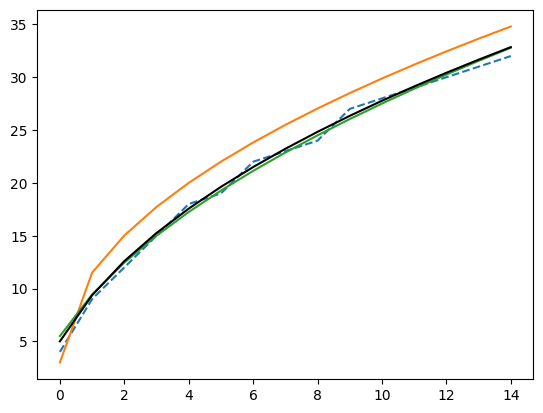

In [74]:
def find_region(x, p):
    cdf = torch.cumsum(p, dim=0)
    tail = (1-0.9973)/2
    left_idx = torch.searchsorted(cdf, tail)
    right_idx = torch.searchsorted(cdf, 1-tail)
    left_value = x[left_idx]
    right_value = x[right_idx]
    return left_value, right_value
stds = []
mads = []
widths = []
max = 15
stride = 10
for degree in range(max):
    fastdstft = fastDSTFT(n_fft=1_000, 
                        stride=stride,
                        initial_win_length=577,
                        window_function='beta',  # 'hann, 'beta'
                        spline_degree = degree,
                        padding = "same"
                        )
    bspline_basis = fastdstft._generate_bspline()
    #print(bspline_basis)
    p = bspline_basis/bspline_basis.sum()
    t = torch.arange(p.shape[0])
    left, right = find_region(t, p)
    if degree==-1:#3:
        plt.plot(p)
        #plt.plot(t, 0.001*torch.ones(p.shape[0]))
        plt.plot([left, right], [0, 0])
        plt.show()
    x = torch.arange(p.shape[0])
    mean = torch.sum(p * x)
    widths.append(right-left)
plt.plot(range(max), torch.tensor(widths), '--')
#plt.plot(range(max), -15+60*torch.tensor(range(max))**(1/3))
#plt.plot(range(max), -2+48.5*torch.tensor(range(max))**(1/2))
#plt.plot(range(max), -2+1.93*stride/2*torch.tensor(range(max))**(1/2))
plt.plot(range(max), 3+1.7*stride/2*torch.tensor(range(max))**(1/2))
plt.plot(range(max), -4/5*(stride/2)+1.9*stride/2*(1+torch.tensor(range(max)))**(1/2))

# this one is good:
a = 1.24
plt.plot(range(max), (1-2*a)*stride/2 + 2*a*stride/2*(1+torch.tensor(range(max)))**(1/2.3), 'k')

print(f"heyy {(1-2*a)*stride/2 + 2*a*stride/2*(1+torch.tensor(0))**(1/2.3)}")

# -2 +1.93*self.spline_stride*torch.sqrt(self.spline_degree)
print(-2 +1.93*25*torch.sqrt(torch.tensor(3)))
print(-2 +1.93*25*3**(1/2))
plt.show()

Fixing the spline alignment

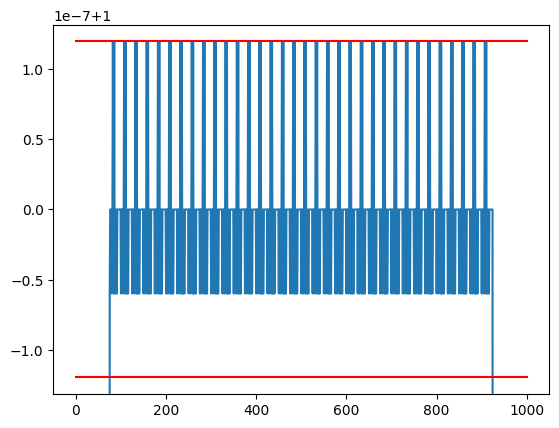

-0.5 49.5 99.5
24.5 74.5 124.5
49.5 99.5 149.5
74.5 124.5 174.5
99.5 149.5 199.5
124.5 174.5 224.5
149.5 199.5 249.5
174.5 224.5 274.5
199.5 249.5 299.5
224.5 274.5 324.5


In [73]:
fastdstft = fastDSTFT(n_fft=1_000, 
                    stride=50,
                    initial_win_length=577,
                    window_function='beta',  # 'hann, 'beta'
                    spline_degree = 3,
                    padding = "same"
                    )

bspline = fastdstft._generate_bspline()
length = len(bspline)
base = torch.zeros(1000)
spline_stride = fastdstft.spline_stride
sum = base.clone()
for i in range(37):
    spline = base.clone()
    spline[i*spline_stride:i*spline_stride+length] = bspline
    sum += spline
plt.plot(sum)
eps = torch.finfo(torch.float32).eps
plt.plot([0, 1000], [1-eps, 1-eps], 'r')
plt.plot([0, 1000], [1+eps, 1+eps], 'r')
plt.ylim([1-1.1*eps, 1+1.1*eps])
plt.show()

start = 0
for i in range(10):
    center = start +(length-1)/2
    end = start +(length-1)
    print(start-0.5, center, end+0.5)  # the spline star, center, and end
    start += 25

Here, the paper ADSTFT is tested

In [ ]:
adstftdevice = "cpu"  # does not work on gpu
from dstft import ADSTFT
x = x_sample.repeat(batch_size, 1).to(adstftdevice)
dstft = ADSTFT(x_sample, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(adstftdevice)

batch_size = 4
spec, *_ = dstft(x)

fwtimes = []
bwtimes = []

lr_decrease = []
lr = opt.param_groups[0]['lr']
errs = []
params = [{'params': dstft.parameters(),'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=19)

for epoch in range(10):
    for param in dstft.parameters():
        param.grad = None

    tic()
    spec, *_ = dstft(x)
    fwtimes.append(toc(print_elapsed=False))

    err = entropy_loss(spec) + reg* (dstft.win_length.diff(dim=0)[:, :-1].pow(2) + dstft.win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs.append(err.item())

    tic()
    err.backward()
    bwtimes.append(toc(print_elapsed=False))

    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < lr:  # lr has decreased
        lr_decrease.append(epoch)
        lr = opt.param_groups[0]['lr']
        if lr < 1:
            break
print(np.mean(fwtimes)/batch_size)
print(np.mean(bwtimes)/batch_size)
print((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
# handles batches of up to 8 at 2.4 per sample, fastest at 4 with 1.1
